<a href="https://www.kaggle.com/code/ericanacletoribeiro/cicids2017-ml-models-comparison-supervised?scriptVersionId=226605896" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Supervised Learning Models for Anomaly-Based Intrusion Detection

This Jupyter Notebook focuses on training and evaluating supervised machine learning models for anomaly-based intrusion detection. It builds upon the preprocessed CICIDS2017 dataset, prepared in the **data preprocessing [notebook available here](https://www.kaggle.com/code/ericanacletoribeiro/cicids2017-comprehensive-data-processing-for-ml)**.

The broader goal is to develop a Network Intrusion Detection System (NIDS) prototype capable of identifying a range of network attacks, such as DoS, PortScan, and Brute Force, while balancing detection accuracy with computational efficiency. This is particularly critical in resource-constrained environments, focus of the project. The complete pipeline is **documented on [Github](https://github.com/anacletu/ml-intrusion-detection-cicids2017)**.

**Models Being Evaluated:**

* **Supervised Learning (This Notebook):**
    * Random Forest
    * XGBoost
    * _k_-NN

* **Unsupervised Learning ([Second Notebook](https://www.kaggle.com/code/ericanacletoribeiro/cicids2017-ml-models-comparison-unsupervised)):**
    * Isolation Forest
    * K-means

**Evaluation Strategy:**

The models are assessed using k-fold cross-validation on the training data, with a separate hold-out test set reserved for final evaluation. Key performance metrics include accuracy, precision, recall, F1-score, and resource usage (CPU time and memory consumption). These metrics provide critical insights into algorithm efficiency and effectiveness, essential for real-time deployment in resource-constrained networks.

This notebook presents the training process, hyperparameter tuning, and comparative analysis of the selected supervised learning models.

In [1]:
# Installing extra components
!pip install memory_profiler
!pip install psutil

In [2]:
# Importing the relevant libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import time
import psutil
import threading
from memory_profiler import memory_usage

import joblib

# Helper Functions

In [3]:
# Apply RF with resource measurements
def apply_rf(X_train, y_train, best_params=None, random_state=42, n_jobs=-1, cv=5):
    """
    Apply Random Forest with resource measurements, including memory, training time, and CPU usage.

    Parameters:
        X_train: Training features.
        y_train: Training labels.
        best_params: Dictionary of best parameters for Random Forest.
        random_state: Random state for reproducibility.
        n_jobs: Number of jobs for parallel processing.
        cv: Number of cross-validation folds.

    Returns:
        cv_scores_rf: Cross-validation scores.
        measurement_rf: Dictionary of memory, training time, and CPU usage.
        rf_model: Trained Random Forest model.
    """
    
    measurement_rf = {}

    # Default to empty dictionary if best_params is not provided
    best_params = best_params or {}

    rf_model = RandomForestClassifier(**best_params, random_state=random_state, n_jobs=n_jobs)
    
    # Function to monitor CPU usage during training
    cpu_usage = []
    stop_flag = threading.Event()

    def monitor_cpu():
        while not stop_flag.is_set():
            cpu_usage.append(psutil.cpu_percent(interval=0.1))

    # Function to train the model
    def train_model():
        rf_model.fit(X_train, y_train)

    try:
        # Start CPU monitoring in a separate thread
        cpu_thread = threading.Thread(target=monitor_cpu)
        cpu_thread.start()

        # Measure memory usage and training time
        start_time = time.time()
        train_memory_rf = max(memory_usage((train_model,)))  # Measure peak memory usage
        training_time = time.time() - start_time

        # Stop CPU monitoring
        stop_flag.set()
        cpu_thread.join()

        # Add measurements
        measurement_rf['Memory Usage (MB)'] = train_memory_rf
        measurement_rf['Training Time (s)'] = training_time
        measurement_rf['Peak CPU Usage (%)'] = max(cpu_usage)
        measurement_rf['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

        # Perform cross-validation
        cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=cv, n_jobs=n_jobs)

        return cv_scores_rf, measurement_rf, rf_model

    except Exception as e:
        print(f"Error during Random Forest training: {e}")
        return None, None, None


In [4]:
# Apply XGBoost with resource measurements
def apply_xgboost(X_train, y_train, best_params=None, random_state=42, n_jobs=-1, cv=5):
    """
    Apply XGBoost with resource measurements, including memory, training time, and CPU usage.

    Parameters:
        X_train: Training features.
        y_train: Training labels.
        best_params: Dictionary of best parameters for XGBoost.
        random_state: Random state for reproducibility.
        cv: Number of cross-validation folds.

    Returns:
        cv_scores_xgb: Cross-validation scores.
        measurement_xgb: Dictionary of memory, training time, and CPU usage.
        xgb_model: Trained XGBoost model.
    """
    
    measurement_xgb = {}

    # Default to empty dictionary if best_params is not provided
    best_params = best_params or {}

    xgb_model = xgb.XGBClassifier(**best_params, objective='multi:softmax', num_class=len(y_train.unique()), random_state=random_state, n_jobs=n_jobs)
    
    # Function to monitor CPU usage during training
    cpu_usage = []
    stop_flag = threading.Event()

    def monitor_cpu():
        while not stop_flag.is_set():
            cpu_usage.append(psutil.cpu_percent(interval=0.1))

    # Function to train the model
    def train_model():
        xgb_model.fit(X_train, y_train)

    try:
        # Start CPU monitoring in a separate thread
        cpu_thread = threading.Thread(target=monitor_cpu)
        cpu_thread.start()

        # Measure memory usage and training time
        start_time = time.time()
        train_memory_xgb = max(memory_usage((train_model,)))  # Measure peak memory usage
        training_time = time.time() - start_time

        # Stop CPU monitoring
        stop_flag.set()
        cpu_thread.join()

        # Add measurements
        measurement_xgb['Memory Usage (MB)'] = train_memory_xgb
        measurement_xgb['Training Time (s)'] = training_time
        measurement_xgb['Peak CPU Usage (%)'] = max(cpu_usage)
        measurement_xgb['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

        # Perform cross-validation
        cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=cv, n_jobs=n_jobs)

        return cv_scores_xgb, measurement_xgb, xgb_model

    except Exception as e:
        print(f"Error during XGBoost training: {e}")
        return None, None, None


In [5]:
# Apply KNN with resource measurements
def apply_knn(X_train, y_train, best_params=None, n_jobs=-1, cv=5):
    """
    Apply K-Nearest Neighbors (KNN) with resource measurements, including memory, training time, and CPU usage.

    Parameters:
        X_train: Training features.
        y_train: Training labels.
        best_params: Dictionary of best parameters for KNN.
        cv: Number of cross-validation folds.

    Returns:
        cv_scores_knn: Cross-validation scores.
        measurement_knn: Dictionary of memory, training time, and CPU usage.
        knn_model: Trained KNN model.
    """
    
    measurement_knn = {}

    # Default to empty dictionary if best_params is not provided
    best_params = best_params or {}

    # Initialize KNN model
    knn_model = KNeighborsClassifier(**best_params, n_jobs=n_jobs)

    # Function to monitor CPU usage during training
    cpu_usage = []
    stop_flag = threading.Event()

    def monitor_cpu():
        while not stop_flag.is_set():
            cpu_usage.append(psutil.cpu_percent(interval=0.1))

    # Function to train the model
    def train_model():
        knn_model.fit(X_train, y_train)

    try:
        # Start CPU monitoring in a separate thread
        cpu_thread = threading.Thread(target=monitor_cpu)
        cpu_thread.start()

        # Measure memory usage and training time
        start_time = time.time()
        train_memory_knn = max(memory_usage((train_model,)))  # Measure peak memory usage
        training_time = time.time() - start_time

        # Stop CPU monitoring
        stop_flag.set()
        cpu_thread.join()

        # Add measurements
        measurement_knn['Memory Usage (MB)'] = train_memory_knn
        measurement_knn['Training Time (s)'] = training_time
        measurement_knn['Peak CPU Usage (%)'] = max(cpu_usage)
        measurement_knn['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

        # Perform cross-validation
        cv_scores_knn = cross_val_score(knn_model, X_train, y_train, cv=cv, n_jobs=n_jobs)

        return cv_scores_knn, measurement_knn, knn_model

    except Exception as e:
        print(f"Error during KNN training: {e}")
        return None, None, None


# 1. Loading and Preparing

In [6]:
# Loading the dataset
clean_df = pd.read_csv('/kaggle/input/cicids2017_cleaned.csv')

In [7]:
clean_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,Attack Type
0,22,1266342,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
1,22,1319353,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
2,22,160,1,0,0,0,0.000000,0.000000,0,0,...,243,0,32,0.0,0,0,0.0,0,0,Normal Traffic
3,22,1303488,41,2728,456,0,66.536585,110.129945,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
4,35396,77,1,0,0,0,0.000000,0.000000,0,0,...,290,0,32,0.0,0,0,0.0,0,0,Normal Traffic


## 1.1. Preparing Training and Test Sets

In [8]:
# Preparing training and test splits
X = clean_df.drop('Attack Type', axis=1)
y = clean_df['Attack Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### 1.1.1. Feature Scaling

Feature scaling is essential for ensuring that all features contribute equally to the model's performance, improving convergence speed, and enhancing the accuracy of machine learning algorithms, particularly those that rely on distance metrics. The first step is to decide on the appropriate type of scaling. To do this, examining outliers and the distribution of features is an effective approach.

* StandardScaler is best for normally distributed data.
* MinMaxScaler is best for bounded features.
* Robust Scaler is best when outliers are present, ensuring that the scaling maintains the robustness of the data.


| **Aspect**             | **StandardScaler**                          | **MinMaxScaler**                          | **RobustScaler**                          |  
|-----------------------|--------------------------------------------|------------------------------------------|-------------------------------------------|  
| **Scaling Approach**  | Mean and standard deviation                 | Minimum and maximum                      | Median and interquartile range            |  
| **Sensitivity to Outliers** | Sensitive (affected by outliers)       | Sensitive (max and min can distort)     | Not sensitive (robust to outliers)        |  
| **Range After Scaling** | Normal distribution (mean=0, sd=1)      | Custom range (default [0,1])            | No fixed range (median is used)           |  
| **Best For**          | Normal distributions                        | Bounded data                             | Data with outliers or non-Gaussian types  |

Based on the [exploratory data analysis (EDA)](https://www.kaggle.com/code/ericanacletoribeiro/cicids2017-comprehensive-data-processing-for-ml), most features exhibit a high percentage of outliers, with values exceeding 10%. As a result, Robust Scaling is likely the most appropriate preprocessing technique. Additionally, statistical tests, such as the Anderson-Darling test (also available on the beforementioned Notebook), indicated that the null hypothesis was rejected for all of the features, confirming that the data does not follow a normal distribution.

In [9]:
# Initialize RobustScaler
scaler = RobustScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test set using the fitted scaler
X_test_scaled = scaler.transform(X_test)

| **Model**                  | **Is Scaling Important?** | **Explanation**                                                                 |
|----------------------------|---------------------------|---------------------------------------------------------------------------------|
| **Random Forest**          | No                       | Random Forest is tree-based and works with the raw values without being affected by scaling. |
| **XGBoost**                | No                       | Like Random Forest, XGBoost is tree-based and insensitive to feature scaling.   |
| **KNN**    | Yes                      | KNN uses distance metrics, which are affected by the scale of features. |

In [10]:
# Exporting the scaler in case it is needed during deployment
joblib.dump(scaler, 'robust_scaler.joblib')

['robust_scaler.joblib']

### 1.1.2. Resampling Techniques

In [11]:
# Checking the distribution of the target variable
clean_df['Attack Type'].value_counts()

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

The dataset shows a considerable imbalance, as already discussed on the [previous notebook](https://www.kaggle.com/datasets/ericanacletoribeiro/cicids2017-cleaned-and-preprocessed). Since cross-validation results are already available without addressing this issue (serving as a benchmark), the decision here is to undersample the majority class to reduce complexity while aiming to maintain performance. This can help the model pay more attention to the less frequent attack types, which are often the focus in intrusion detection systems.

In [12]:
# Initializing the undersampling for the clean df
X_train_resampled, y_train_resampled = RandomUnderSampler(sampling_strategy={'Normal Traffic': 500000}, random_state=42).fit_resample(X_train, y_train)

# Initializing the undersampling for the scaled df
X_train_scaled, y_train_scaled = RandomUnderSampler(sampling_strategy={'Normal Traffic': 500000}, random_state=42).fit_resample(X_train_scaled, y_train)

In order to further balance the training set, we can also partially oversample the minority classes with SMOTE. _Synthetic Minority Over-sampling Technique_ is a widely-used method to address class imbalance in datasets by generating synthetic samples for the minority class, rather than merely duplicating existing ones. The values were chosen based on the value_counts above: all in all, rouding up the numbers in order to avoid an overly aggressive oversampling.

In [13]:
# Initializing the oversampling for the scaled df
X_train_resampled_scaled, y_train_resampled_scaled = SMOTE(sampling_strategy={'Bots': 2000, 'Web Attacks': 2000, 'Brute Force': 7000, 'Port Scanning': 70000, 'DDoS':90000, 'DoS': 200000}, random_state=42).fit_resample(X_train_scaled, y_train_scaled)

Since SMOTE relies on distance calculations to generate synthetic samples, it is essential to scale the dataset beforehand to ensure that all features contribute equally to the interpolation process and avoid skewed or meaningless synthetic data. Therefore, this process will not be applied to the raw training data.

In [14]:
# Cleaning up
del X_train_scaled, X_train, y_train, X, y, clean_df

In [15]:
# Checking the distribution of the attack types in the resampled/raw training set
y_train_scaled.value_counts()

Attack Type
Normal Traffic    500000
DoS               135621
DDoS               89610
Port Scanning      63486
Brute Force         6405
Web Attacks         1500
Bots                1364
Name: count, dtype: int64

In [16]:
# Checking the distribution of the attack types in the resampled/scaled training set
y_train_resampled_scaled.value_counts()

Attack Type
Normal Traffic    500000
DoS               200000
DDoS               90000
Port Scanning      70000
Brute Force         7000
Bots                2000
Web Attacks         2000
Name: count, dtype: int64

### 1.1.3. A Note on PCA

During the experimentation process, PCA (Principal Component Analysis) was considered as a dimensionality reduction technique to speed up model training and improve computational efficiency. While PCA proved effective in accelerating training for algorithms like KNN, it introduced an additional preprocessing step in the pipeline, which is not ideal for real-time production environments. Production systems prioritize simplicity and speed, and the need to transform new data using PCA before making predictions could potentially impact real-time performance.

Moreover, the dataset exhibited strong correlations among features, causing PCA to converge the variance into just one or two principal components. While this initially seemed promising due to the high explained variance ratio, these components failed to fully capture the intricacies of the data. This led to poorer results in terms of model performance, as the reduced representation lacked the necessary granularity to differentiate between classes effectively. Based on these observations, PCA was ultimately excluded from the workflow to maintain a balance between computational efficiency, simplicity, and model performance on production.

# 2. Supervised Learning

## 2.1. Random Forest

Random Forest is robust to variance in the data. Therefore, it can be trained on the non-scaled version of the dataset without a significant impact on performance.

### 2.1.1. Hyperparameter Tuning*

To determine the optimal parameters for machine learning models, it's crucial to evaluate how different hyperparameters affect performance. A good way to do this is by visualizing the model's performance across various configurations, using techniques such as RandomizedSearchCV or GridSearchCV.

While an exhaustive grid search is often recommended for thorough hyperparameter optimization through cross-validation (CV), this process can be computationally expensive and time-consuming. Given the performance constraints of this project, the goal here is to simplify the search by using RandomizedSearchCV. This approach randomly samples parameter combinations and checks if they can outperform the standard parameter settings of each model.

***Due to resources limitations on Kaggle, this section was run locally, results are shown at the end**

In [17]:
# # Defining the parameters for the Random Forest Classifier
# param_grid = {
#     'n_estimators': [100, 150, 200],
#     'max_depth': [20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2'],
# }

In [18]:
# Creating the Random Forest Classifier
# rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

In [19]:
# # Saving results with the standard parameters
# cv_sc_rf = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=3, n_jobs=-1)
# cv_sc_rf = np.mean(cv_sc_rf)

# # Apply RandomizedSearchCV
# random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=20, cv=3, n_jobs=-1, verbose=2)
# random_search_rf.fit(X_train_resampled, y_train_resampled)

In [20]:
# # Get the best parameters
# print(f'Best Parameters: {random_search_rf.best_params_}')
# print(f"Best Cross-Validation Score: {random_search_rf.best_score_}")
# print(f"Cross-Validation from Standard: {cv_sc_rf}")

# best_params_rf = random_search_rf.best_params_ if random_search_rf.best_score_ > cv_sc_rf else None

# del random_search_rf

**A Note on Hyperparameter Tuning**

Due to the stochastic nature of RandomizedSearchCV, the values for each parameter might differ every time this notebook is run. To ensure reproducibility, the following parameters were selected as the best-performing ones for the Random Forest model in this experiment:

Best Parameters: 
- `n_estimators`: 200
- `min_samples_split`: 5
- `min_samples_leaf`: 2
- `max_features`: 'sqrt'
- `max_depth`: None

If you wish to replicate my results, these are the parameters that provided the optimal performance for this model.

In [21]:
# Defining manually due to Kaggle performance limitations
best_params_rf = {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}

### 2.1.2. Fitting the Random Forest

In [22]:
# Fitting the model
cv_scores_rf, measurement_rf, rf_model = apply_rf(X_train_resampled, y_train_resampled, best_params=best_params_rf)

# Making predictions
y_pred_rf = rf_model.predict(X_test)

In [23]:
# Evaluating the model performance on the cross validation set vs accuracy on the test set
cv_scores_mean_rf = np.mean(cv_scores_rf)
print(f'Cross validation average score: {cv_scores_mean_rf:.4f} +/- standard deviation: {np.std(cv_scores_rf):.4f}')

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy on the test set: {accuracy_rf:.4f}')

Cross validation average score: 0.9987 +/- standard deviation: 0.0001
Accuracy on the test set: 0.9988


In [24]:
# Checking computational cost
print("Resource measurements:", measurement_rf)

Resource measurements: {'Memory Usage (MB)': 3063.796875, 'Training Time (s)': 280.24524426460266, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 99.38010869565221}


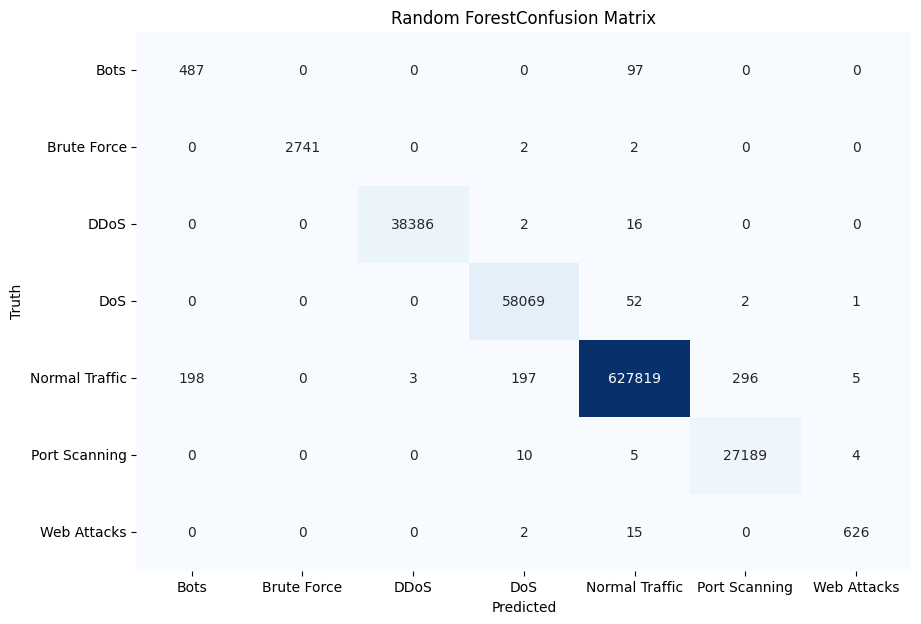

In [25]:
# Evaluating the model via confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Random ForestConfusion Matrix')
plt.show()

In [26]:
# Classification report
print(classification_report(y_test, y_pred_rf))

                precision    recall  f1-score   support

          Bots       0.71      0.83      0.77       584
   Brute Force       1.00      1.00      1.00      2745
          DDoS       1.00      1.00      1.00     38404
           DoS       1.00      1.00      1.00     58124
Normal Traffic       1.00      1.00      1.00    628518
 Port Scanning       0.99      1.00      0.99     27208
   Web Attacks       0.98      0.97      0.98       643

      accuracy                           1.00    756226
     macro avg       0.95      0.97      0.96    756226
  weighted avg       1.00      1.00      1.00    756226



With a mean cross-validation score of 0.9987 and an accuracy score of 0.9988, the model demonstrates strong performance without signs of underfitting or overfitting (your numbers might differ due to different results from RamdomizedSearchCV). Additionally, the confusion matrix reveals a significant improvement in recall (from 0.74 to 0.83) for the 'Bots' class compared to the benchmark model ([available here](https://www.kaggle.com/code/ericanacletoribeiro/cicids2017-comprehensive-data-processing-for-ml)).
While the precision score for the same class decreased from 0.86 to 0.71, the trade-off is justified in the context of a NIDS. In such systems, minimizing false negatives is crucial, as undetected threats can compromise network security. False positives, while inconvenient, are less harmful than false negatives. This improvement in recall indicates that the model is now better at detecting 'Bots' attacks, validating the effectiveness of fine-tuning techniques for this dataset.

### 2.1.3. Exporting the Model

In [27]:
# Save the model to a file
joblib.dump(rf_model, 'random_forest.joblib')

['random_forest.joblib']

## 2.2. XGBoost

XGBoost (Extreme Gradient Boosting) is a highly efficient implementation of gradient boosting, which is known for its power in handling imbalanced datasets, preventing overfitting, and its ability to work well with both structured and unstructured data. In this section, we will evaluate XGBoost for the task of anomaly-based intrusion detection.

While Random Forest is an ensemble method that builds multiple decision trees independently, XGBoost takes a more iterative approach, building trees sequentially, where each new tree attempts to correct errors made by the previous one. This results in a model that often outperforms Random Forest in terms of predictive accuracy, particularly for complex datasets.

### 2.2.1. Hyperparameter Tuning*

***Due to resources limitations on Kaggle, this section was run locally, results are showns at the end**

In [28]:
# # Defining the parameter grid for XGBoost
# param_dist = {
#     'n_estimators': [100, 150, 200],
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.2, 0.3, 0.4],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0],
#     'min_child_weight': [1, 5, 10],
# }

XGBoost's `multi:softmax` objective requires numerical labels for classification. Therefore, a mapping is necessary to convert categorical labels into numerical values before training the model.

In [29]:
# # Creating the XGBoost Classifier
# xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y_train_resampled.unique()), random_state=42, n_jobs=-1)

# Custom mapping for the attack types
label_mapping = {
    'Normal Traffic': 0,
    'DoS': 1,
    'DDoS': 2,
    'Port Scanning': 3,
    'Brute Force': 4,
    'Web Attacks': 5,
    'Bots': 6
}
y_train_resampled_mapped = y_train_resampled.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

In [30]:
# # Saving results with the standard parameters
# cv_sc_xgb = cross_val_score(xgb_model, X_train_resampled, y_train_resampled_mapped, cv=3, n_jobs=-1)
# cv_sc_xgb = np.mean(cv_sc_xgb)

# # Perform RandomizedSearchCV
# random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=30, cv=3, n_jobs=-1, verbose=2, random_state=42)
# random_search_xgb.fit(X_train_resampled, y_train_resampled_mapped)

In [31]:
# # Best parameters found by RandomizedSearchCV
# print(f'Best Parameters for XGBoost: {random_search_xgb.best_params_}')
# print(f"Best Cross-Validation Score: {random_search_xgb.best_score_}")
# print(f"Cross-Validation from Standard: {cv_sc_xgb}")

# best_params_xgb = random_search_xgb.best_params_ if random_search_xgb.best_score_ > cv_sc_xgb else None

# del random_search_xgb

**A Note on Hyperparameter Tuning**

Due to the stochastic nature of RandomizedSearchCV, the values for each parameter might differ every time this notebook is run. To ensure reproducibility, the following parameters were selected as the best-performing ones for the XGBoost model in this experiment:

Best Parameters: 
- `subsample`: 1.0
- `n_estimators`: 150
- `min_child_weight`: 1
- `max_depth`: 3
- `learning_rate`: 0.3
- `colsample_bytree`: 0.7

If you wish to replicate my results, these are the parameters that provided the optimal performance for this model.


In [32]:
# Defining parameters manually due to Kaggles performance limitataions
best_params_xgb = {'subsample': 1.0, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.7}

### 2.2.2. Fitting the XGBoost

In [33]:
# Fitting the model
cv_scores_xgb, measurement_xgb, xgb_model = apply_xgboost(X_train_resampled, y_train_resampled_mapped, best_params=best_params_xgb)

# Making predictions
y_pred_xgb = xgb_model.predict(X_test)

In [34]:
# Evaluating the model performance on the cross validation set vs accuracy on the test set
cv_scores_mean_xgb = np.mean(cv_scores_xgb)
print(f'Cross validation average score: {cv_scores_mean_xgb:.4f} +/- standard deviation: {np.std(cv_scores_xgb):.4f}')

accuracy_xgb = accuracy_score(y_test_mapped, y_pred_xgb)
print(f'Accuracy on the test set: {accuracy_xgb:.4f}')

Cross validation average score: 0.9991 +/- standard deviation: 0.0001
Accuracy on the test set: 0.9990


In [35]:
# Checking computational cost
print("Resource measurements:", measurement_xgb)

Resource measurements: {'Memory Usage (MB)': 3356.53125, 'Training Time (s)': 72.70299077033997, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 99.00890125173852}


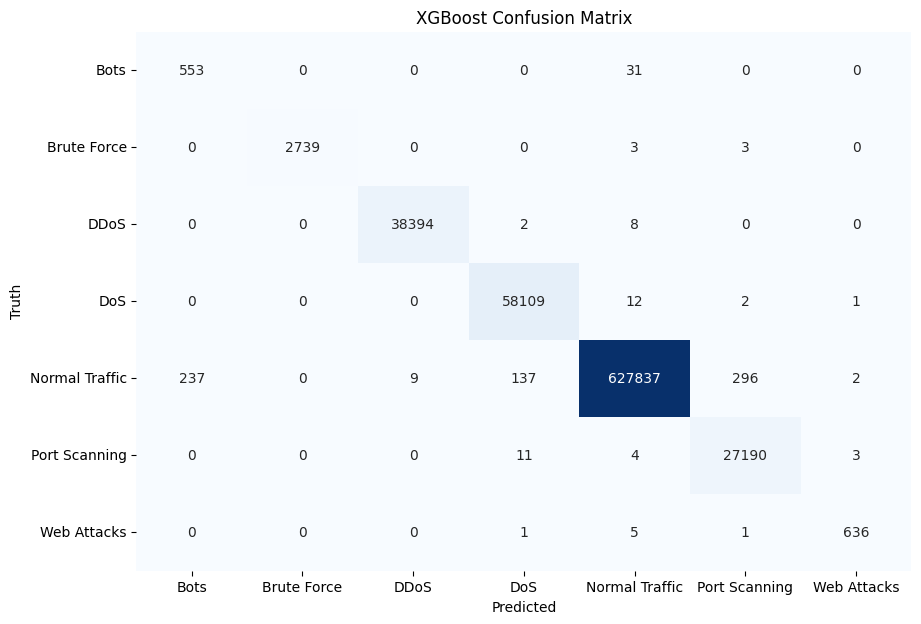

In [36]:
# Remapping the labels for visualization
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
predicted_labels = [reverse_label_mapping[pred] for pred in y_pred_xgb]
actual_labels = sorted([reverse_label_mapping[label] for label in xgb_model.classes_])

# Confusion matrix
cm_xgb = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_xgb, annot=True, fmt='d', xticklabels=actual_labels, yticklabels=actual_labels, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('XGBoost Confusion Matrix')
plt.show()

In [37]:
# Classification report
print(classification_report(y_test, predicted_labels))

                precision    recall  f1-score   support

          Bots       0.70      0.95      0.80       584
   Brute Force       1.00      1.00      1.00      2745
          DDoS       1.00      1.00      1.00     38404
           DoS       1.00      1.00      1.00     58124
Normal Traffic       1.00      1.00      1.00    628518
 Port Scanning       0.99      1.00      0.99     27208
   Web Attacks       0.99      0.99      0.99       643

      accuracy                           1.00    756226
     macro avg       0.95      0.99      0.97    756226
  weighted avg       1.00      1.00      1.00    756226



The XGBoost model demonstrated a significant improvement in recall for the 'Bots' class compared to the Random Forest model. Recall is a critical metric for this application, as undetected attacks can compromise network security. The difference between the two models across other metrics, including accuracy, precision, and overall F1-score, remains negligible, with a marginal advantage to XGB.

### 2.2.3. Exporting the Model

In [38]:
# Save the model to a file
joblib.dump(xgb_model, 'xgboost.joblib')

['xgboost.joblib']

## 2.3. K-Nearest Neighbors (KNN)

K-Nearest Neighbors (KNN) is a simple and effective classification algorithm that works by finding the majority class among the `k` nearest data points for a given instance. It is sensitive to the scale of the data, so it is important to ensure that the features are standardized (scaled).

### 2.3.1. Hyperparamenter Tuning*

***Due to resources limitations on Kaggle, this section was run locally, results are showns at the end**

In [39]:
# # Defining the parameters for KNN
# param_grid_knn = {
#     'n_neighbors': [3, 5, 7],
#     'weights': ['uniform', 'distance'],
# }

In [40]:
# # Creating the KNN model
# knn_model = KNeighborsClassifier(n_jobs=-1)

In [41]:
# # Saving results with the standard parameters
# cv_sc_knn = cross_val_score(knn_model, X_train_resampled_scaled, y_train_resampled_scaled, cv=3, n_jobs=-1)
# cv_sc_knn = np.mean(cv_sc_knn)

# # Apply RandomizedSearchCV
# random_search_knn = RandomizedSearchCV(estimator=knn_model, param_distributions=param_grid_knn, n_iter=6, cv=3, n_jobs=-1, verbose=2)
# random_search_knn.fit(X_train_resampled_scaled, y_train_resampled_scaled)

In [42]:
# # Get the best parameters
# print(f'Best Parameters: {random_search_knn.best_params_}')
# print(f"Best Cross-Validation Score: {random_search_knn.best_score_}")
# print(f"Cross-Validation from Standard: {cv_sc_knn}")

# best_params_knn = random_search_knn.best_params_ if random_search_knn.best_score_ > cv_sc_knn else None

# del random_search_knn

Best Parameters:

- `weights`: distance
- `n_neighbours`: 3

In [43]:
# Defining manually
best_params_knn = {'weights': 'distance', 'n_neighbors': 3}

### 2.3.2. Fitting the KNN

In [44]:
# Fitting the model
cv_scores_knn, measurement_knn, knn_model = apply_knn(X_train_resampled_scaled, y_train_resampled_scaled, best_params=best_params_knn)

# Making predictions
y_pred_knn = knn_model.predict(X_test_scaled)

In [45]:
# Evaluating the model performance on the cross-validation set vs accuracy on the test set
cv_scores_mean_knn = np.mean(cv_scores_knn)
print(f'Cross-validation average score: {cv_scores_mean_knn:.4f} +/- standard deviation: {np.std(cv_scores_knn):.4f}')

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy on the test set: {accuracy_knn:.4f}')

Cross-validation average score: 0.9881 +/- standard deviation: 0.0007
Accuracy on the test set: 0.9890


In [46]:
# Checking computational cost
print("Resource measurements:", measurement_knn)

Resource measurements: {'Memory Usage (MB)': 3018.0703125, 'Training Time (s)': 1.842740535736084, 'Peak CPU Usage (%)': 28.6, 'Average CPU Usage (%)': 22.975}


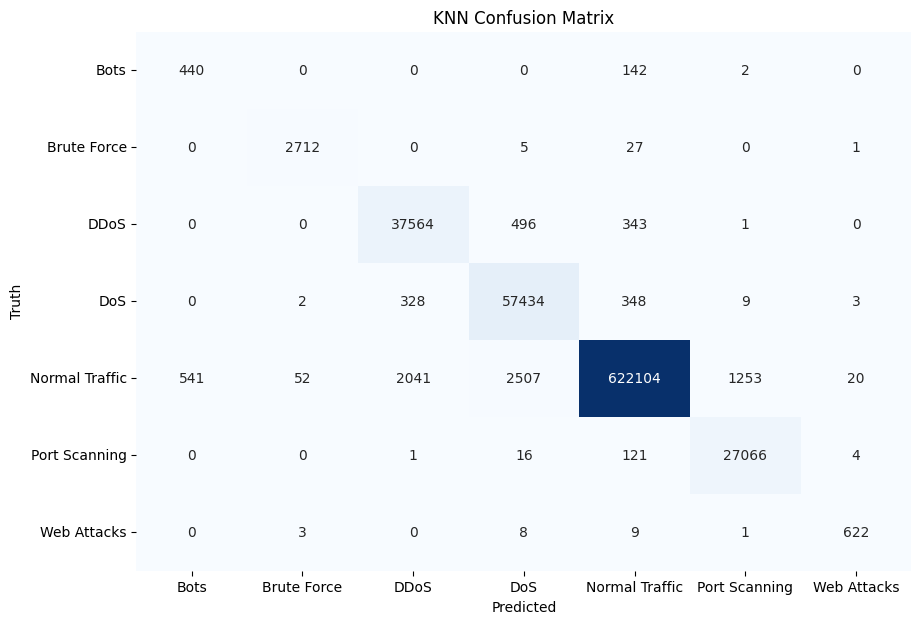

In [47]:
# Evaluating the model via confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_knn, annot=True, fmt='d', xticklabels=knn_model.classes_, yticklabels=knn_model.classes_, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('KNN Confusion Matrix')
plt.show()

In [48]:
# Classification report
print(classification_report(y_test, y_pred_knn))

                precision    recall  f1-score   support

          Bots       0.45      0.75      0.56       584
   Brute Force       0.98      0.99      0.98      2745
          DDoS       0.94      0.98      0.96     38404
           DoS       0.95      0.99      0.97     58124
Normal Traffic       1.00      0.99      0.99    628518
 Port Scanning       0.96      0.99      0.97     27208
   Web Attacks       0.96      0.97      0.96       643

      accuracy                           0.99    756226
     macro avg       0.89      0.95      0.91    756226
  weighted avg       0.99      0.99      0.99    756226



The KNN model also demonstrated strong performance, though it was slightly outperformed by the previous models. However, it is worth noting that the 'Bots' class remains the weakest in the dataset, with consistently lower values across all evaluation metrics.

### 2.1.3. Exporting the Model

In [49]:
# Save the model to a file
joblib.dump(knn_model, 'knn_model.joblib')

['knn_model.joblib']

# 3. Comparing Performance Results

In [50]:
# Calculating precision, recall, and F1 score for each model
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

precision_xgb = precision_score(y_test_mapped, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test_mapped, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test_mapped, y_pred_xgb, average='weighted')

precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

In [51]:
# Creating the results dataframe
supervised_results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'KNN'],
    'Accuracy': [accuracy_rf, accuracy_xgb, accuracy_knn],
    'Cross Validation Mean': [cv_scores_mean_rf, cv_scores_mean_xgb, cv_scores_mean_knn],
    'Precision': [precision_rf, precision_xgb, precision_knn],
    'Recall': [recall_rf, recall_xgb, recall_knn],
    'F1 Score': [f1_rf, f1_xgb, f1_knn],
    'Memory Usage (MB)': [measurement_rf['Memory Usage (MB)'], measurement_xgb['Memory Usage (MB)'], measurement_knn['Memory Usage (MB)']],
    'Training Time (s)': [measurement_rf['Training Time (s)'], measurement_xgb['Training Time (s)'], measurement_knn['Training Time (s)']],
    'Peak CPU Usage (%)': [measurement_rf['Peak CPU Usage (%)'], measurement_xgb['Peak CPU Usage (%)'], measurement_knn['Peak CPU Usage (%)']],
    'Average CPU Usage (%)': [measurement_rf['Average CPU Usage (%)'], measurement_xgb['Average CPU Usage (%)'], measurement_knn['Average CPU Usage (%)']],
})

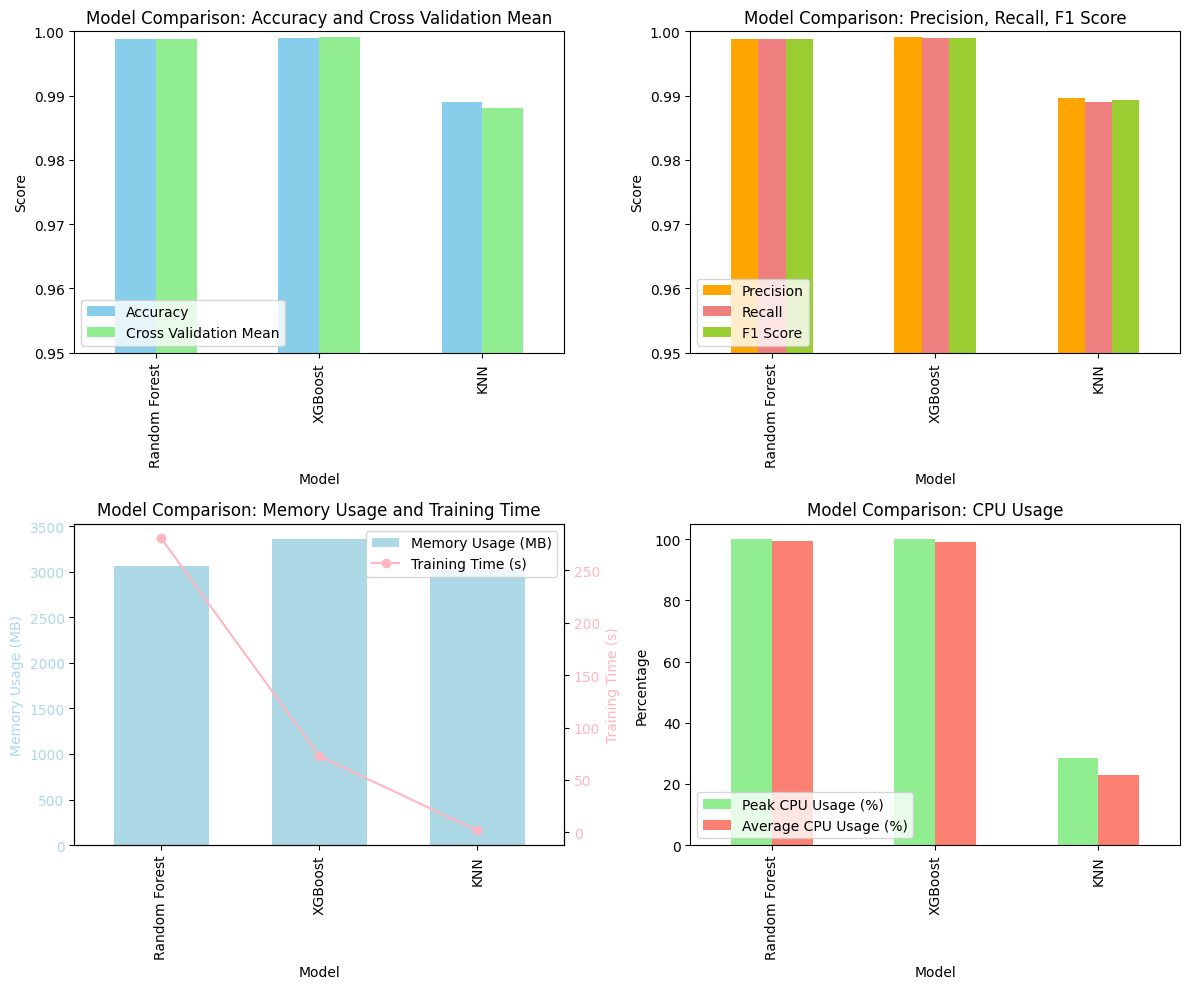

In [52]:
# Plotting the comparison for accuracy, cross-validation, and metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plotting Accuracy and Cross Validation Mean
supervised_results.set_index('Model')[['Accuracy', 'Cross Validation Mean']].plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'lightgreen'], legend=True)
axes[0, 0].set_title('Model Comparison: Accuracy and Cross Validation Mean')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylim(0.95, 1.0)
axes[0, 0].legend(loc='lower left')

# Plotting Precision, Recall, F1 Score
supervised_results.set_index('Model')[['Precision', 'Recall', 'F1 Score']].plot(kind='bar', ax=axes[0, 1], color=['orange', 'lightcoral', 'yellowgreen'], legend=True)
axes[0, 1].set_title('Model Comparison: Precision, Recall, F1 Score')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylim(0.95, 1.0)
axes[0, 1].legend(loc='lower left')

# Plotting Memory Usage and Training Time
ax1 = axes[1, 0]

supervised_results.set_index('Model')['Memory Usage (MB)'].plot(
    kind='bar', ax=ax1, color='lightblue', label='Memory Usage (MB)', width=0.6
)
ax1.set_ylabel('Memory Usage (MB)', color='lightblue')
ax1.tick_params(axis='y', labelcolor='lightblue')

ax2 = ax1.twinx() 
supervised_results.set_index('Model')['Training Time (s)'].plot(
    ax=ax2, color='lightpink', marker='o', label='Training Time (s)'
)
ax2.set_ylabel('Training Time (s)', color='lightpink')
ax2.tick_params(axis='y', labelcolor='lightpink')

ax1.set_title('Model Comparison: Memory Usage and Training Time')
ax1.set_xlabel('Model')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Plotting Peak and Average CPU Usage
supervised_results.set_index('Model')[['Peak CPU Usage (%)', 'Average CPU Usage (%)']].plot(kind='bar', ax=axes[1, 1], color=['lightgreen', 'salmon'], legend=True)
axes[1, 1].set_title('Model Comparison: CPU Usage')
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].set_xlabel('Model')
axes[1, 1].legend(loc='lower left')

plt.tight_layout()
plt.show()

The plots effectively illustrate the performance of each model during training and testing phases. While Random Forest (RF) and XGBoost (XGB) achieved the highest accuracy and test scores, they also demanded more computational power. On the other hand, it's important to remember that KNN is a 'lazy learner,' meaning that actual training occurs when new data is introduced, either during testing or in production. The true performance of KNN will become clearer once the prototype is deployed and tested in real-time.